###  Automotive Catalytic Converter 

The catalyst light-off temperature is a minimum temperature to initiate the catalytic reaction. Before light-off temperature is reached, the catalytic converter is less effective at reducing the pollutants. A typical light-off temperature is between 400 to 600 degrees F. The normal operating temperature is between 750 to 1,600 degrees F. The operating temperature increases with more pollutants in the exhaust.

**Method**  AutoRegressive model with eXogenous input (ARX) time series models are a linear representation of a dynamic system in discrete time. The term exogeneos is related to the fact of being influenced from external parameters. The model relates the current value of a time series to both: i) past values of the same series; and
ii) current and past values of the driving (exogenous) series — that is, of the externally determined series that influences the series of interest. Putting a model into ARX form is the basis for many methods in process dynamics and control analysis. 

**Objective** Create an ARX model of the catalytic temperature and coolant temperature based on the vehicle speed. This project makes use of GEKKO python-based package to set the ARX model.

**Data**. Data was collected by Prof. J. D. Green from the Brigham Young university. It includes travel distance, time, fuel rate, air flow, oxygen ratio, and other parameters available from an OBD2 interface. 

### Import Packages

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Data and View Columns

Import `auto_warmup.csv`, set time index, and print data columns

In [49]:
data = pd.read_csv('auto_trip.csv')

# set time index
data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time')

# print data columns
for x in data.columns:
    print(x)

Absolute load value (%)
Absolute pedal position D (%)
Altitude (GPS) (feet)
Ambient air temperature (℉)
Average fuel consumption (MPG)
Average fuel consumption (total) (MPG)
Average fuel consumption 10 sec (MPG)
Average speed (mph)
Average speed (GPS) (mph)
Barometric pressure (kPa)
Calculated boost (bar)
Calculated engine load value (%)
Calculated instant fuel consumption (MPG)
Calculated instant fuel rate (gal./h)
Catalyst temperature Bank 1 Sensor 1 (℉)
Distance to empty (miles)
Distance travelled (miles)
Distance travelled (total) (miles)
Engine coolant temperature (℉)
Engine RPM (rpm)
Fuel economizer (based on fuel system status and throttle position) ()
Fuel level input (%) (%)
Fuel level input (V) (gallon)
Fuel used (gallon)
Fuel used (total) (gallon)
Fuel used price ($)
Fuel used price (total) ($)
Fuel/Air commanded equivalence ratio ()
Instant engine power (based on fuel consumption) (hp)
Intake air temperature (℉)
MAF air flow rate (g/sec)
Oxygen sensor 1 Wide Range Current (

### Select Columns of Interest

In [50]:
# select columns of interest
data1 = data[['Engine coolant temperature (℉)']].copy()
data1.dropna(inplace=True)
data2 = data[['Catalyst temperature Bank 1 Sensor 1 (℉)']].copy()
data2.dropna(inplace=True)
data3 = data[['Vehicle speed (mph)']].copy()

In [51]:
# join data
data = data1.join(data2,how='outer',sort=True)
data = data.join(data3,how='outer',sort=True)
data.columns = ['coolant (degF)','catalyst (degF)','speed (mph)']
data

coolant (degF)  catalyst (degF)  speed (mph)
time                                                                 
2022-09-04 07:50:22.160             NaN              NaN          NaN
2022-09-04 07:50:22.266             NaN              NaN          NaN
2022-09-04 07:50:22.273             NaN              NaN          NaN
2022-09-04 07:50:22.274             NaN              NaN          NaN
2022-09-04 07:50:22.306             NaN              NaN          NaN
...                                 ...              ...          ...
2022-09-04 20:32:29.455             NaN              NaN          NaN
2022-09-04 20:32:29.752             NaN              NaN          NaN
2022-09-04 20:32:29.902             NaN              NaN          NaN
2022-09-04 20:32:30.040             NaN              NaN          NaN
2022-09-04 20:32:30.052             NaN              NaN    21.747992

[291866 rows x 3 columns]

In [52]:
# fill in NaNs - forward fill
data.fillna(method='ffill',inplace=True)
# fill in NaNs - backward fill
data.fillna(method='bfill',inplace=True)
dr = len(data)
data.describe()

coolant (degF)  catalyst (degF)    speed (mph)
count   291866.000000    291866.000000  291866.000000
mean       199.541963      1439.703879      70.136529
std         10.334619       201.723939      23.152111
min        116.600000       162.140000       0.000000
25%        194.000000      1435.640000      74.564543
50%        199.400000      1483.520000      78.914141
75%        206.600000      1532.840000      81.399626
max        374.000000      7514.600000     121.788754

### Plot Data

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

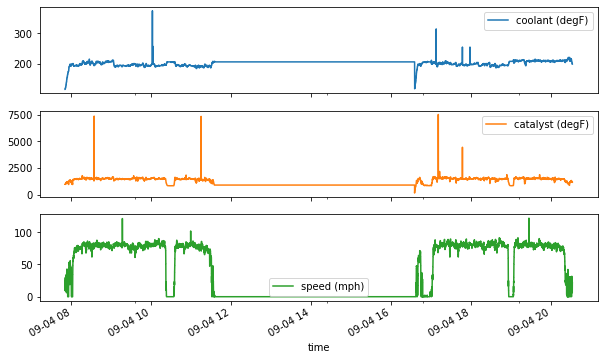

In [53]:
data.plot(subplots=True,figsize=(10,6))

### Remove Gross Outliers

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

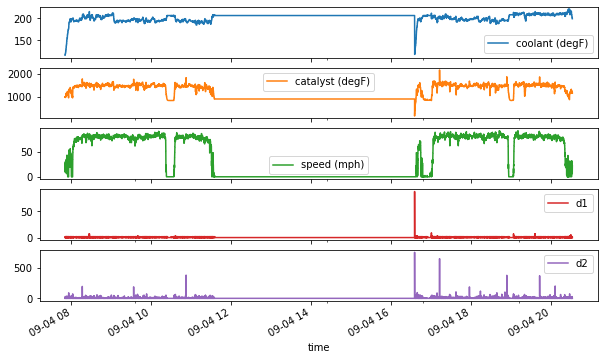

In [54]:
# data cleansing
data = data[data['coolant (degF)']<250]
data = data[data['speed (mph)']<100]
data = data[data['catalyst (degF)']<3800]

data['d1'] = data['coolant (degF)'].diff().abs()
data['d2'] = data['catalyst (degF)'].diff().abs()
data.plot(subplots=True,figsize=(10,6))

### Remove Other Outliers and Bad Speed Data

Rows removed:  443  of  291866


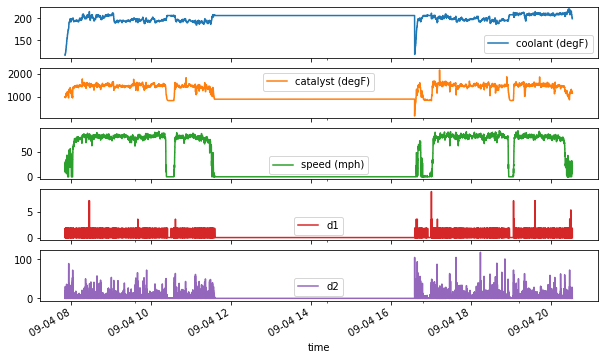

In [55]:
# 3 cycles because cat temperature stays high for a few samples
for i in range(3):
    data['d1'] = data['coolant (degF)'].diff().abs()
    data['d2'] = data['catalyst (degF)'].diff().abs()
    data = data[data['d1']<29]
    data = data[data['d2']<139]

data.plot(subplots=True,figsize=(10,6))
print('Rows removed: ',dr-len(data), ' of ', dr)

In [56]:
# delete d1 and d2
del data['d1']
del data['d2']

<AxesSubplot:xlabel='time'>

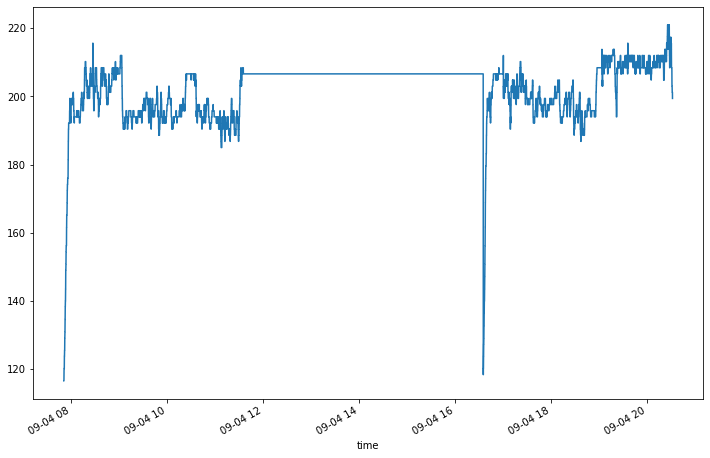

In [57]:
data['coolant (degF)'].plot(figsize=(12,8))

In [58]:
data_wind = data.iloc[data.index.indexer_between_time('11:00', '16:52' )]
data_wind[data_wind['coolant (degF)'] < 180.4]

coolant (degF)  catalyst (degF)  speed (mph)
time                                                                 
2022-09-04 16:35:30.888           118.4           169.70          0.0
2022-09-04 16:35:31.110           118.4           169.70          0.0
2022-09-04 16:35:31.162           118.4           169.70          0.0
2022-09-04 16:35:31.163           118.4           169.70          0.0
2022-09-04 16:35:31.170           118.4           169.70          0.0
...                                 ...              ...          ...
2022-09-04 16:39:07.229           179.6          1173.74          0.0
2022-09-04 16:39:07.237           179.6          1173.74          0.0
2022-09-04 16:39:07.247           179.6          1173.74          0.0
2022-09-04 16:39:07.248           179.6          1173.74          0.0
2022-09-04 16:39:07.329           179.6          1173.74          0.0

[1897 rows x 3 columns]

In [59]:
del data_wind
# data.iloc[data.index.indexer_between_time('16:35:31', '16:39:06' )]
# data.index.indexer_between_time('16:35:31', '16:39:06' )
#data_new.drop(pd.Timestamp('2022-09-04 16:35:31.110'))
#data_new = data_wind.drop(pd.date_range('2022-09-04 16:35:30.888','2022-09-04 16:39:07.329', freq="S"))
# data.reindex(data.index-data.index.take(data.loc[data.index.indexer_between_time('16:35:31', '16:39:06' )]))
#data_new[data_new['coolant (degF)'] < 180.4]

In [60]:
#data_wind.drop([data.index.indexer_between_time('16:35:31', '16:39:06' )], axis=0)
#data_new.index.indexer_between_time('16:36:30','16:39:07')
#data_new.drop(['2022-09-04 16:35:31.110000', '2022-09-04 16:38:59.139000'])
#data_new[(data_new.index >= '2022-09-04 16:39:06.141')]
#data_new.index >= '2022-09-04 16:39:06.141'
#data_new[~((data_new.index >= '2022-09-04 16:35:31.110') | (data_new.index >= '2022-09-04 16:35:31.110'))]
data = data[~((data.index >= '2022-09-04 16:35:30.888') & (data.index <= '2022-09-04 16:39:07.329'))]

In [61]:
data.index

DatetimeIndex(['2022-09-04 07:50:22.274000', '2022-09-04 07:50:22.306000',
               '2022-09-04 07:50:22.447000', '2022-09-04 07:50:22.548000',
               '2022-09-04 07:50:22.694000', '2022-09-04 07:50:22.791000',
               '2022-09-04 07:50:22.916000', '2022-09-04 07:50:23.007000',
               '2022-09-04 07:50:23.176000', '2022-09-04 07:50:23.261000',
               ...
               '2022-09-04 20:32:29.320000', '2022-09-04 20:32:29.321000',
               '2022-09-04 20:32:29.322000', '2022-09-04 20:32:29.323000',
               '2022-09-04 20:32:29.349000', '2022-09-04 20:32:29.455000',
               '2022-09-04 20:32:29.752000', '2022-09-04 20:32:29.902000',
               '2022-09-04 20:32:30.040000', '2022-09-04 20:32:30.052000'],
              dtype='datetime64[ns]', name='time', length=289526, freq=None)

In [62]:
#data_range.index

### Display Cleansed Data

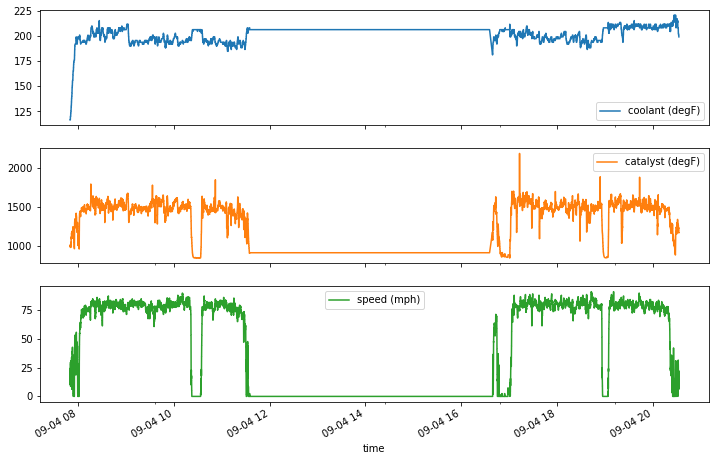

In [63]:
data[['coolant (degF)','catalyst (degF)', 'speed (mph)']].plot(subplots=True, figsize=(12,8))
plt.savefig('auto_time.png',dpi=300)
data.to_csv('auto_clean.csv')

In [64]:
# data_range.drop(columns="tmin")
data.columns
# data.iloc[data.index.indexer_between_time('06:24:46','06:55:01'), 3] = 1

Index(['coolant (degF)', 'catalyst (degF)', 'speed (mph)'], dtype='object')

### Create ARX Model

In [65]:
# reduce data to about every 1-2 sec
data = data[::10].copy()

data['tmin'] = data.index
t0 = data['tmin'].iloc[0]
dt = (data['tmin'].copy()-t0)
dt2 = []
for i in range(len(data)):
    dt2.append(dt[i].total_seconds()/60.0)
data['tmin'] = dt2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


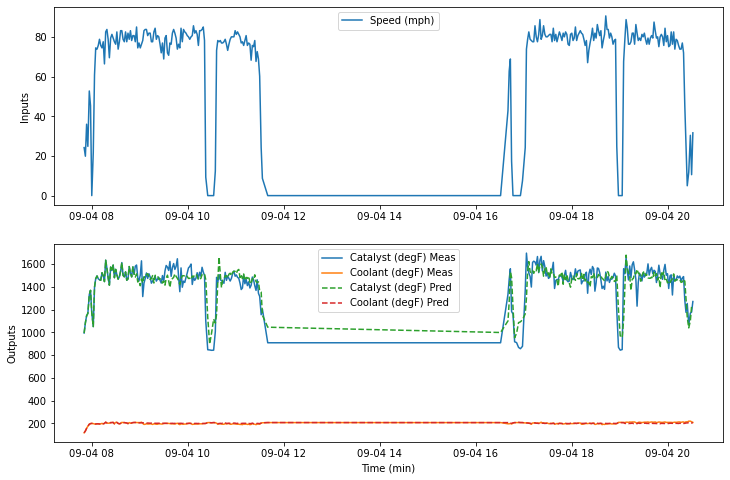

In [70]:
from gekko import GEKKO

t = data_range['tmin'].values
u = data_range[['speed (mph)']].values
y = data_range[['catalyst (degF)','coolant (degF)']].values

# generate time-series model
m = GEKKO(remote=False)

# system identification
na = 2 # output coefficients
nb = 40 # input coefficients
yp,p,K = m.sysid(t,u,y,na,nb,pred='meas')

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend(['Speed (mph)'],loc=9)
plt.ylabel('Inputs')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp,'--')
plt.legend(); plt.ylabel('Outputs')
plt.legend(['Catalyst (degF) Meas','Coolant (degF) Meas',\
            'Catalyst (degF) Pred','Coolant (degF) Pred'],loc=9)

plt.xlabel('Time (min)'); plt.savefig('sysid.png')
plt.show()